In [433]:
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import scipy
from scipy import linalg
from matplotlib import pyplot
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from scipy.stats import pearsonr
import math
from matplotlib import cm


## Import Raw Data

In [64]:
rawdata = pd.read_csv(r'C:\Users\Student\Desktop\usedcar\usedCar_Dataset_titleUpdate.csv')
rawdata = rawdata.reset_index(drop=True)

## Initial Review

In [379]:
rawdata.head()

,CarID,MakeId,Title,Make,Model,Trim,BodyStyle,Rental,Location,GasMileage_city,...,Engine,Drivetrain,VIN,OptionCount,MajorOptions,Certified,Accident Check,OwnershipHistory,SellingDays,OriginPrice
0,100351603,m1,"2007 Chevrolet Tahoe - $11,999",Chevrolet,Tahoe,NaN,suv,NaN,"Garland, TX",NaN,...,V8,NaN,1GNFC13J47R120389,0,NaN,NaN,0.0,2.0,1873,12999.0
1,101113873,m1,"2005 Chevrolet Express - $11,995",Chevrolet,Express,NaN,van,NaN,"Claremont, NH",NaN,...,NaN,NaN,1GBJG31U251136588,0,NaN,NaN,1.0,1.0,1863,NaN
2,102996725,m1,2010 Chevrolet Silverado 2500HD Work Truck Ext...,Chevrolet,Silverado 2500HD,Work Truck Extended Cab LB 4WD,pickup_truck,NaN,"Frankfort, KY",NaN,...,V8,Four-Wheel Drive,1GC5KVBG7AZ218246,2,"Steel Wheels,Tow Package",NaN,0.0,2.0,1837,16900.0
3,103384798,m1,2014 Chevrolet Corvette Stingray 3LT Coupe RWD...,Chevrolet,Corvette,Stingray 3LT Coupe RWD,coupe,NaN,"Lewistown, MT",17 MPG City,...,V8,Rear-Wheel Drive,1G1YE2D73E5104797,5,"Bluetooth,Backup Camera,Aluminum Wheels,Naviga...",NaN,0.0,1.0,1832,62900.0
4,104800849,m1,"2002 Chevrolet Monte Carlo SS FWD - $3,440",Chevrolet,Monte Carlo,SS FWD,coupe,NaN,"Delavan, IL",17 MPG City,...,V6,Front-Wheel Drive,2G1WX15K829249749,2,"Leather Seats,Aluminum Wheels",NaN,0.0,2.0,1809,4800.0


In [380]:
rawdata.columns

Index(['CarID', 'MakeId', 'Title', 'Make', 'Model', 'Trim', 'BodyStyle',
       'Rental', 'Location', 'GasMileage_city', 'GasMileage_highway', 'Price',
       'Mileage', 'Transmission', 'FuelType', 'ExteriorColor', 'InteriorColor',
       'DoorsNum', 'MaximumSeating', 'Engine', 'Drivetrain', 'VIN',
       'OptionCount', 'MajorOptions', 'Certified', 'Accident Check',
       'OwnershipHistory', 'SellingDays', 'OriginPrice'],
      dtype='object')

In [381]:
rawdata.describe()

,CarID,Price,Mileage,OptionCount,Accident Check,OwnershipHistory,SellingDays,OriginPrice
count,2.375350e+06,2.247208e+06,2.339351e+06,2.375350e+06,2.343021e+06,2.304644e+06,2.375350e+06,1.251224e+06
mean,2.550147e+08,2.075144e+04,6.395459e+04,3.683289e+00,2.043038e-01,1.645522e+00,7.348521e+01,3.160004e+04
std,9.813719e+06,1.877066e+04,5.008891e+04,3.118477e+00,4.963621e-01,1.024763e+00,1.076277e+02,9.270913e+06
min,1.994620e+07,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,2.535240e+08,1.199300e+04,2.709700e+04,1.000000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.399700e+04
50%,2.579329e+08,1.789500e+04,4.705000e+04,3.000000e+00,0.000000e+00,1.000000e+00,4.200000e+01,1.999400e+04
75%,2.601602e+08,2.599900e+04,9.217600e+04,5.000000e+00,0.000000e+00,2.000000e+00,9.000000e+01,2.890000e+04
max,2.618259e+08,3.838600e+06,2.400000e+06,6.400000e+01,8.000000e+00,1.900000e+01,3.341000e+03,1.037026e+10


In [382]:
rawdata.isnull().sum()

CarID                       0
MakeId                      0
Title                       0
Make                        0
Model                       0
Trim                   110407
BodyStyle                3245
Rental                1971633
Location                    0
GasMileage_city        468531
GasMileage_highway     468531
Price                  128142
Mileage                 35999
Transmission            43703
FuelType                56003
ExteriorColor           57451
InteriorColor          414585
DoorsNum              1139822
MaximumSeating         115232
Engine                  60814
Drivetrain             115321
VIN                      2239
OptionCount                 0
MajorOptions           310832
Certified             2130888
Accident Check          32329
OwnershipHistory        70706
SellingDays                 0
OriginPrice           1124126
dtype: int64

## Data Cleaning


In [383]:
car_dataframe = rawdata.copy()

The title column and the Location column contains multiple values that need to be split into multiple columns

In [384]:
#Split Location column into two columns called Location & State separately
Location_split = car_dataframe['Location'].str.split(', ', n=1, expand=True)
car_dataframe.drop(columns=['Location'], inplace=True)
car_dataframe.insert(2,'Location',Location_split[0])
car_dataframe.insert(3,'State',Location_split[1])
car_dataframe=car_dataframe.reset_index(drop=True)
car_dataframe.drop(car_dataframe[car_dataframe.State=='California'].index, inplace=True)

#Title split into Year and Title columns
Title_split = car_dataframe['Title'].str.split(' -', n=1, expand=True)
car_dataframe.drop(columns=['Title'], inplace=True)
car_dataframe.insert(0,'Title',Title_split[0])
brand_year_split = car_dataframe['Title'].str.split(r'^(\d{4})', n=1, expand=True)
car_dataframe.drop(columns=['Title'], inplace=True)
car_dataframe.insert(0, 'Title', brand_year_split[2])
car_dataframe.insert(1, 'Year', brand_year_split[1])
car_dataframe['Year'] = car_dataframe['Year'].astype(int)

In [385]:
#the data prior to 2000 are obsolete
car_dataframe[car_dataframe['Year']<2000].isnull().sum()

Title                     0
Year                      0
CarID                     0
MakeId                    0
Location                  0
State                     0
Make                      0
Model                     0
Trim                   9808
BodyStyle              1243
Rental                30088
GasMileage_city       21332
GasMileage_highway    21332
Price                  2916
Mileage                3843
Transmission           2528
FuelType              10079
ExteriorColor          2322
InteriorColor          7911
DoorsNum              13528
MaximumSeating        12679
Engine                10327
Drivetrain            12566
VIN                     281
OptionCount               0
MajorOptions          20140
Certified             30559
Accident Check         9640
OwnershipHistory       9981
SellingDays               0
OriginPrice           18633
dtype: int64

In [386]:
car_dataframe = car_dataframe.drop(car_dataframe[car_dataframe['Year']<2000].index)

Take a closer look at the pearson method on the table.

In [387]:
car_dataframe.corr(method='pearson')

,Year,CarID,Price,Mileage,OptionCount,Accident Check,OwnershipHistory,SellingDays,OriginPrice
Year,1.000000,0.094770,0.361953,-0.776629,0.239095,-0.218918,-0.587049,-0.094641,0.000378
CarID,0.094770,1.000000,-0.017363,-0.050409,0.005093,-0.036403,-0.085508,-0.999605,0.000266
Price,0.361953,-0.017363,1.000000,-0.392143,0.241135,-0.139160,-0.224025,0.015841,0.007700
Mileage,-0.776629,-0.050409,-0.392143,1.000000,-0.212296,0.221252,0.510478,0.051012,-0.001450
OptionCount,0.239095,0.005093,0.241135,-0.212296,1.000000,-0.077089,-0.158414,-0.006441,0.001510
Accident Check,-0.218918,-0.036403,-0.139160,0.221252,-0.077089,1.000000,0.194943,0.036145,-0.000611
OwnershipHistory,-0.587049,-0.085508,-0.224025,0.510478,-0.158414,0.194943,1.000000,0.084679,-0.000914
SellingDays,-0.094641,-0.999605,0.015841,0.051012,-0.006441,0.036145,0.084679,1.000000,-0.000296
OriginPrice,0.000378,0.000266,0.007700,-0.001450,0.001510,-0.000611,-0.000914,-0.000296,1.000000


In [388]:
#Unnecessary columns or columns with too many NA values
car_dataframe = car_dataframe.drop(columns='Rental')
car_dataframe = car_dataframe.drop(columns='VIN')
car_dataframe = car_dataframe.drop(columns='Certified')
car_dataframe = car_dataframe.drop(columns='ExteriorColor')
car_dataframe = car_dataframe.drop(columns='InteriorColor')
car_dataframe = car_dataframe.drop(columns='CarID')
car_dataframe = car_dataframe.drop(columns='MakeId')
car_dataframe = car_dataframe.drop(columns='Trim')
car_dataframe = car_dataframe.drop(columns='MajorOptions')
car_dataframe = car_dataframe.drop(columns='DoorsNum')


In [389]:
#drop the low relevent columns with price
car_dataframe = car_dataframe.drop(columns='MaximumSeating')
car_dataframe = car_dataframe.drop(columns='SellingDays')
car_dataframe = car_dataframe.drop(columns='OriginPrice')


In [390]:
#Drop all of the missing values of all columns except gasmileage columns
car_dataframe = car_dataframe.drop(car_dataframe[car_dataframe['Transmission'].isna()].index)
car_dataframe = car_dataframe.drop(car_dataframe[car_dataframe['FuelType'].isna()].index)
car_dataframe = car_dataframe.drop(car_dataframe[car_dataframe['BodyStyle'].isna()].index)
car_dataframe = car_dataframe.drop(car_dataframe[car_dataframe['Accident Check'].isna()].index)
car_dataframe = car_dataframe.drop(car_dataframe[car_dataframe['OwnershipHistory'].isna()].index)
car_dataframe = car_dataframe.drop(car_dataframe[car_dataframe['Engine'].isna()].index)
car_dataframe = car_dataframe.drop(car_dataframe[car_dataframe['Drivetrain'].isna()].index)
car_dataframe = car_dataframe.drop(car_dataframe[car_dataframe['Price'].isna()].index)
car_dataframe = car_dataframe.drop(car_dataframe[car_dataframe['Mileage'].isna()].index)

car_dataframe = car_dataframe.reset_index(drop=True)

In [391]:
#convert the dtype of gasmileage columns to float
car_dataframe['GasMileage_city'] = car_dataframe['GasMileage_city'].str.extract(r'^(\d*)').astype(float)
car_dataframe['GasMileage_highway'] = car_dataframe['GasMileage_highway'].str.extract(r'^(\d*)').astype(float)


In [392]:
nan_mileage = set()
for i in car_dataframe['Model'].unique():
    if all(car_dataframe[car_dataframe['Model']==i]['GasMileage_city'].isna()):
        nan_mileage.add(i)
    if all(car_dataframe[car_dataframe['Model']==i]['GasMileage_highway'].isna()):
        nan_mileage.add(i)

In [393]:
car_dataframe = car_dataframe.drop(car_dataframe[car_dataframe['Model'].isin(nan_mileage)].index)

In [394]:
car_dataframe.isnull().sum()

Title                      0
Year                       0
Location                   0
State                      0
Make                       0
Model                      0
BodyStyle                  0
GasMileage_city       212280
GasMileage_highway    212280
Price                      0
Mileage                    0
Transmission               0
FuelType                   0
Engine                     0
Drivetrain                 0
OptionCount                0
Accident Check             0
OwnershipHistory           0
dtype: int64

In [395]:
#Impute the missing values of each model with the average fuel efficiency of each model
for i in car_dataframe[car_dataframe['GasMileage_highway'].isna()]['Model'].unique():   
    car_dataframe.loc[car_dataframe[(car_dataframe['Model']==i)&(car_dataframe['GasMileage_city'].isna())].index, 'GasMileage_city'] = car_dataframe[car_dataframe['Model']==i]['GasMileage_city'].mean()
    car_dataframe.loc[car_dataframe[(car_dataframe['Model']==i)&(car_dataframe['GasMileage_highway'].isna())].index, 'GasMileage_highway'] = car_dataframe[car_dataframe['Model']==i]['GasMileage_highway'].mean()

Even though the missing values are all imputed, we still have the problem of various values of fuel efficiency given that the same car model we checked out.
Thus, the values of gas mileage columns must be adjusted to average value of each model's fuel efficiency.

In [396]:
for i in car_dataframe['Model'].unique():
    car_dataframe.loc[car_dataframe[car_dataframe['Model']==i].index, 'GasMileage_city'] = car_dataframe[car_dataframe['Model']==i]['GasMileage_city'].mean()
    car_dataframe.loc[car_dataframe[car_dataframe['Model']==i].index, 'GasMileage_highway'] = car_dataframe[car_dataframe['Model']==i]['GasMileage_highway'].mean()

Then, check the distribution of each column if there's any significant outlier.

In [397]:
car_dataframe.groupby('State').mean()

,Year,GasMileage_city,GasMileage_highway,Price,Mileage,OptionCount,Accident Check,OwnershipHistory
State,,,,,,,,
AL,2014.871642,19.929324,27.179338,20329.356906,66914.991624,3.836850,0.256786,1.644329
AR,2015.447140,19.081301,26.041031,22490.777172,60690.498594,3.814972,0.135338,1.538084
AZ,2014.464508,20.767729,28.190493,18547.731591,63419.945770,3.480078,0.161113,1.764169
CA,2014.901386,21.602773,28.951375,21051.277221,56464.145384,3.855477,0.122972,1.535506
CO,2014.436779,20.270486,27.260999,20607.998376,64692.488986,3.794630,0.182307,1.682824
CT,2014.554050,20.993812,28.357893,19520.242378,57912.919852,4.140543,0.233730,1.470037
DC,2010.156250,20.617556,27.888081,15118.531250,132984.218750,4.093750,0.250000,3.062500
DE,2014.553768,20.742739,28.155724,19729.124682,60828.906647,3.625106,0.135690,1.494073
FL,2015.075761,20.793117,28.247307,20469.344071,54502.063827,3.659585,0.312319,1.635560


As we can see the mileage record in DC showed relatively higher than the others.

In [398]:
car_dataframe[(car_dataframe['State']=='DC')&(car_dataframe['Mileage']>150000)]

,Title,Year,Location,State,Make,Model,BodyStyle,GasMileage_city,GasMileage_highway,Price,Mileage,Transmission,FuelType,Engine,Drivetrain,OptionCount,Accident Check,OwnershipHistory
797744,Cadillac CTS 3.6L RWD,2005,Washington,DC,Cadillac,CTS,sedan,18.650872,27.471151,1000.0,1675000.0,Automatic,Gasoline,V6,Rear-Wheel Drive,1,1.0,5.0
1154612,BMW X3 2.5i AWD,2004,Washington,DC,BMW,X3,crossover,20.538226,27.475626,2900.0,163000.0,Automatic,Gasoline,I6,All-Wheel Drive,4,1.0,3.0


Considering there might be other mileage outliers, we'll remove all of them at once.

In [399]:
car_dataframe = car_dataframe.drop(car_dataframe[car_dataframe['Mileage']>150000].index)

Price outliers are left to be removed

In [400]:
#Drop the outliers with price over three hundred thousand
car_dataframe = car_dataframe.drop(car_dataframe[car_dataframe['Price'] > 300000].index)
car_dataframe = car_dataframe.reset_index(drop=True)

In [401]:
#Remove the outliers in each model with price over or lower than three times of each model's price deviation
for value in car_dataframe['Model'].unique():
    price = car_dataframe[car_dataframe['Model']==value]['Price']
    price_index = price[((price-price.mean())/price.std() > 3) | ((price-price.mean())/price.std() < -3)].index
    car_dataframe = car_dataframe.drop(price_index)
car_dataframe = car_dataframe.reset_index(drop=True)

## Exploratory Data Analysis

In [402]:
car_dataframe = pd.read_csv(r'C:/Users/Student/Desktop/usedcar/sorted_result.csv')

First step, we are about to check the marketshare of each car brand and its median price

In [403]:
brand_marketshare = car_dataframe.groupby('Make')['Title'].count()
brand_marketshare = brand_marketshare.reset_index()
percentage = round(brand_marketshare['Title']/brand_marketshare['Title'].sum(),4)*100
percentage = percentage.apply(lambda x:'%.2f'%x)+'%'
brand_marketshare['Percentage'] = percentage
brand_price = car_dataframe.groupby('Make')['Price'].mean()
brand_price = brand_price.reset_index()
brand_marketshare = pd.merge(brand_marketshare, brand_price, on='Make')
brand_marketshare = brand_marketshare.sort_values(by=['Title'], ascending=True)
brand_marketshare['Price'] = round(brand_marketshare['Price'],0).astype(int)
brand_marketshare

,Make,Title,Percentage,Price
37,Plymouth,32,0.00%,28233
42,SRT,32,0.00%,88937
20,Isuzu,70,0.00%,5199
36,Oldsmobile,137,0.01%,3256
31,McLaren,243,0.01%,158215
51,smart,402,0.02%,6784
41,Rolls-Royce,407,0.02%,179908
24,Lamborghini,469,0.03%,185351
2,Aston Martin,485,0.03%,87146
17,Hummer,510,0.03%,11733


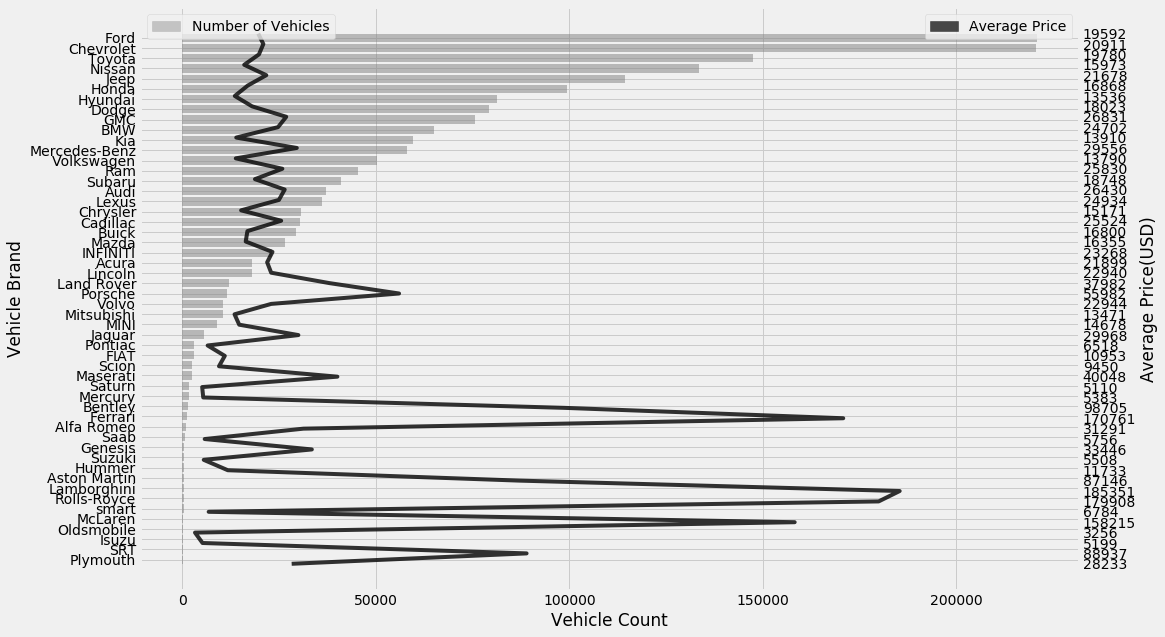

In [404]:
fig, ax1 = plt.subplots(figsize=(15,10))
Vehicle_Count = brand_marketshare['Title']
Vehicle_Cost = brand_marketshare['Price']
ax2=ax1.twinx()
ax1.barh(brand_marketshare.Make, Vehicle_Count, alpha=0.5,color='gray', linewidth=2)
ax2.plot(Vehicle_Cost, brand_marketshare.Make, alpha=0.8,color='black', linewidth=4)
ax2.axes.set_yticklabels(Vehicle_Cost)
ax2.grid(b=False)
ax1.set_ylabel('Vehicle Brand')
ax1.set_xlabel('Vehicle Count')
ax2.set_ylabel('Average Price(USD)')

black_patch = mpatches.Patch(alpha=0.7, color='black', label='Average Price')
gray_patch = mpatches.Patch(alpha=0.4, color='gray', label='Number of Vehicles')
first_legend = plt.legend(handles=[black_patch], loc=0)
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[gray_patch], loc=2)
plt.show()

As we can find out that the brands with quite low marketshare are tend to be at the high level of volatile prices at which are not easy to be dealt with machine learning. Thus, the strategy might be removing the brands with extreme low marketshare.
Here i set the threshold for marketshare must be more than 1% for removing the unqualified brands.

In [405]:
car_dataframe = car_dataframe[car_dataframe['Make'].isin(list(brand_marketshare['Make'][32:]))]

#### Comparison of State  Income &  Vehicle Cost

For the analysis of this subject we require to import the support data which contains the relative information of all the states in the U.S.

In [10]:
state_result = pd.read_csv(r'../Student/Desktop/usedcar/StateResult.csv')
state_result

,State,Median Household Income(USD),Income Ranking,Abbreviation,Price,Cost Ranking,Density,Pop,LandArea,Vehicle Count
0,District of Columbia,82604,1,DC,15996.43333,50,11665.0984,711571,61,30
1,New Jersey,79363,3,NJ,20129.29658,37,1213.2917,8922547,7354,56606
2,Massachusetts,77378,5,MA,20498.55510,30,889.6632,6939373,7800,45750
3,Connecticut,76106,7,CT,19728.15029,41,736.8589,3567871,4842,24745
4,Maryland,81868,2,MD,20735.48031,22,624.5923,6062917,9707,33186
5,Delaware,65627,15,DE,20040.93712,38,500.2735,975033,1949,4469
6,New York,65323,16,NY,21651.26752,11,413.6005,19491339,47126,72452
7,Florida,53267,37,FL,20459.35458,32,403.6579,21646155,53625,133991
8,Ohio,54533,34,OH,18650.85729,47,286.7910,11718568,40861,77793
9,Pennsylvania,59445,22,PA,20033.56861,39,286.3905,12813969,44743,77660


Price regression line as a favorable option for this plot.

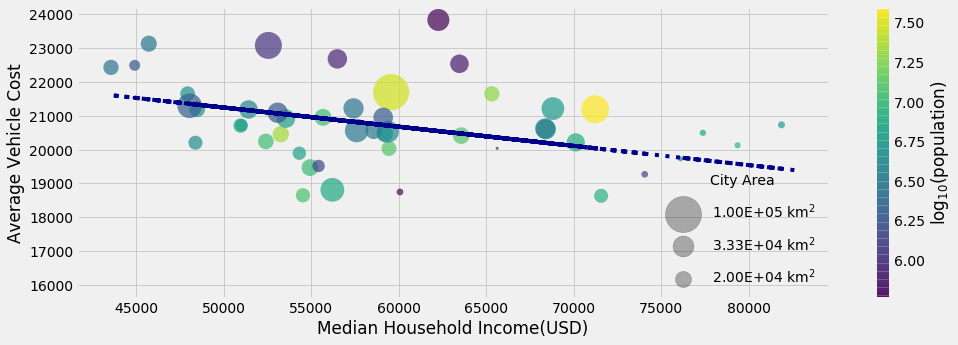

In [415]:
income_cost_fit = np.polyfit(state_result['Median Household Income(USD)'], state_result['Price'],1)
income_cost_fit
plt.style.use('fivethirtyeight')
Income, Cost = state_result['Median Household Income(USD)'], state_result['Price']
Population, Area = state_result['Pop'], state_result['LandArea']
fig, ax = plt.subplots(figsize=(15,5))
scatter = ax.scatter(Income, Cost, c=np.log10(Population), cmap='viridis', s=Area/50, linewidths=0, alpha=0.7, marker=".")

plt.plot(state_result['Median Household Income(USD)'], income_cost_fit[0]*state_result['Median Household Income(USD)']+income_cost_fit[1],
        linewidth=4, color ='darkblue', linestyle=':')
plt.xlabel('Median Household Income(USD)')
plt.ylabel('Average Vehicle Cost')
fig.colorbar(scatter, label='log$_{10}$(population)')

for area in [100, 300, 500]:
    plt.scatter([], [], c='k', alpha=0.3, s=Area/area,
                label=str(format(1/area*10000000, "9.2E")) + ' km$^2$')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='City Area', loc='lower right')


The regression dotted line shows the negative relation with income and vehicle price. Interestingly to say, the support data indicates that the states with median household income around 75,000 or even higher are tend to be with low land area(compared to the others)and also with lower vehicle price. While the states with higher prices shows relatively low in median household income and population but quiet larger in land area.
Next step, we'll check how the distribution of these vehicles affected the regression line.

We divided the states in to three groups based on Q1 and Q3 of interquartile range.
The median price of each bodystyle in three groups are shown below and the price gap differentiated by three bars in each bodystyle group.

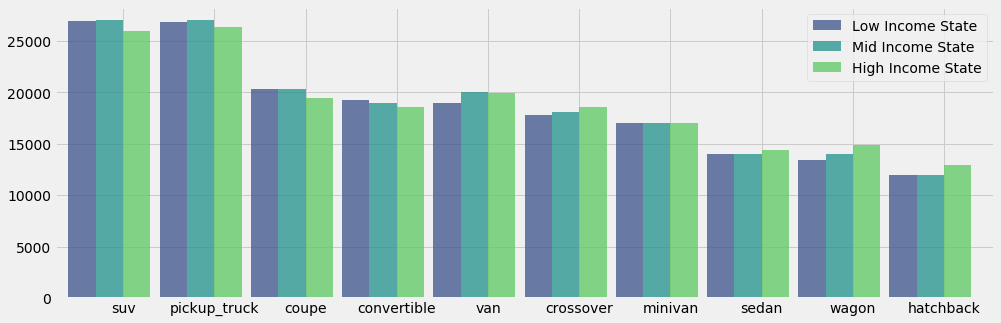

In [474]:
low_income_series = pd.Series(data=car_dataframe[car_dataframe['State'].isin(state_result[state_result['Median Household Income(USD)'] <= 55000]['Abbreviation'])].groupby('BodyStyle')['Price'].median(), name='Low Income State')
median_income_series = pd.Series(data=car_dataframe[car_dataframe['State'].isin(state_result[(state_result['Median Household Income(USD)']>55000)&(state_result['Median Household Income(USD)'] <= 65000)]['Abbreviation'])].groupby('BodyStyle')['Price'].median(), name='Median Income State')
high_income_series = pd.Series(data=car_dataframe[car_dataframe['State'].isin(state_result[state_result['Median Household Income(USD)'] > 65000]['Abbreviation'])].groupby('BodyStyle')['Price'].median(), name='High Income State')
state_income_bodystyle= pd.DataFrame(data=[low_income_series,median_income_series, high_income_series]).T
state_income_bodystyle = state_income_bodystyle.sort_values(by='Low Income State', ascending=False)
plt.style.use('fivethirtyeight')
width=0.3
pos=list(range(len(state_income_bodystyle.index)))
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(pos, state_income_bodystyle['Low Income State'], width, alpha=0.75, color=plt.cm.viridis(0.25), label='Low Income State')
ax.bar([p+width for p in pos], state_income_bodystyle['Median Income State'], width, alpha=0.75, color=plt.cm.viridis(0.5))
ax.bar([p+width*2 for p in pos], state_income_bodystyle['High Income State'], width, alpha=0.75, color=plt.cm.viridis(0.75))
ax.set_xticks([p + 1.5*width for p in pos])
ax.set_xticklabels(state_income_bodystyle.index)
plt.xlim(min(pos)-width, max(pos)+1)
plt.legend(['Low Income State', 'Mid Income State', 'High Income State'])


The price gap in each group wasn't significant. So the average prices of three groups would be just fine.

Next, i'll demonstrate the marketshare of each bodystyle in each group by the line plots with the previous bodystyle index on x-axis. Here i add the barplot as the average prices of three gorups.

Text(0.5, 0, 'BodyStyle')

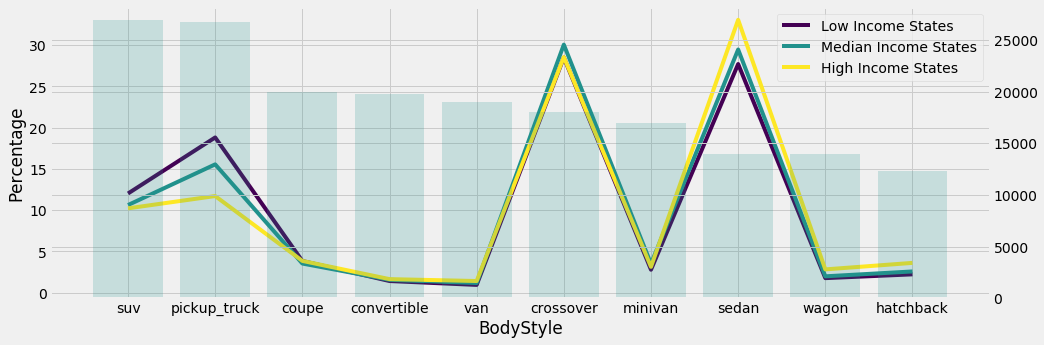

In [501]:
low_income_df = pd.Series(data=car_dataframe[car_dataframe['State'].isin(state_result[state_result['Median Household Income(USD)'] < state_result['Median Household Income(USD)'].quantile(.25)]['Abbreviation'])].groupby('BodyStyle')['Model'].count(), name='Low Income States')
median_income_df = pd.Series(data=car_dataframe[car_dataframe['State'].isin(state_result[(state_result['Median Household Income(USD)'] >= state_result['Median Household Income(USD)'].quantile(.25))&(state_result['Median Household Income(USD)'] <= state_result['Median Household Income(USD)'].quantile(.75))]['Abbreviation'])].groupby('BodyStyle')['Model'].count(), name='Median Income States')
high_income_df = pd.Series(data=car_dataframe[car_dataframe['State'].isin(state_result[state_result['Median Household Income(USD)'] > state_result['Median Household Income(USD)'].quantile(.75)]['Abbreviation'])].groupby('BodyStyle')['Model'].count(), name='High Income States')
state_model_count = pd.DataFrame(data=[low_income_df, median_income_df, high_income_df]).T
for colnum in state_model_count.columns:
    state_model_count[colnum] = round(state_model_count[colnum]/ state_model_count[colnum].sum()*100, 2)
state_model_count = state_model_count.loc[state_income_bodystyle.index]
fig, axes = plt.subplots(figsize=(15,5))
np_idx = np.linspace(0,1,3)
for i, num in zip(state_model_count.columns, np_idx):
    axes.plot(state_model_count.index, state_model_count[i], color=plt.cm.viridis(num))
axes2 = plt.twinx()
axes2.bar(state_model_count.index, car_dataframe.groupby('BodyStyle')['Price'].median().sort_values(ascending=False), alpha=0.2, color=plt.cm.viridis(0.5))
axes.legend(state_model_count.columns, loc='upper right')
axes.set_ylabel('Percentage')
axes.set_xlabel('BodyStyle')

The result indicateds that the vehicles with higher prices in bodystyle shows more percentage of vehicles in lower income states than the others, especially such as suv and pickup truck. Only the sedan type shows the obvious percentage gap between three groups but at quite low price ranking.
That's why lower median income group shows more average vehicle price than the others.